In [1]:
import os
import sys

top_dir = os.path.split(os.getcwd())[0]
sys.path.append(top_dir)
sys.path.append(os.path.join(top_dir, "src"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

%load_ext lab_black

In [3]:
def autolabel(ax, orient="h", fmt="{:,f}", xytext=(5, -4), **kwargs):
    """Automatically labels the rectangles in a (vertical) bar chart.
    """

    for rect in ax.patches:
        if orient == "h":
            size = rect.get_width()
            xy = (size, rect.get_y())
        else:
            size = rect.get_height()
            xy = (rect.get_x() + rect.get_width() / 2, size)
        if size != 0:
            ax.annotate(
                fmt.format(size),
                xy=xy,
                xytext=xytext,
                textcoords="offset points",
                ha="center",
                va="bottom",
                **kwargs,
            )


def get_colnames(genres, metric_names):
    return [f"{name}_{genre}" for name in metric_names for genre in genres]


def build_df(results, metric_names):
    genres = results[metric_names[0]].keys()
    data = np.r_[
        [np.array(results[key][genre]) for key in metric_names for genre in genres]
    ]
    return pd.DataFrame(data.T, columns=get_colnames(genres, metric_names))

In [6]:
# Load the results
model_name = os.listdir("../results")[0]
fpath = os.path.join("../results", model_name, "C2P_results.json")

with open(fpath, "r") as f:
    results = json.load(f)

# Create dataframes
chromas = build_df(results, ["chroma_similarities"])
style_macro = build_df(results, ["macro_time_pitch_diff", "macro_onset_duration"])
style_per_song = build_df(
    results, ["per_song_time_pitch_diff", "per_song_onset_duration"]
)

nano_metrics = pd.concat([chromas, style_per_song], axis=1)

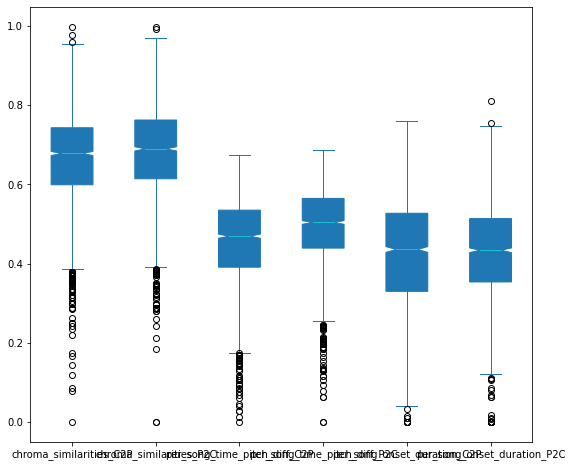

In [30]:
fig, ax = plt.subplots(figsize=(9, 8))

n_colors = len(nano_metrics.columns)
colors = [plt.cm.tab10.colors]

# ax.set_prop_cycle(color=colors)

boxes = nano_metrics.plot.box(
    notch=True, patch_artist=True, labels=nano_metrics.columns, ax=ax, cmap="tab10"
)
plt.show()

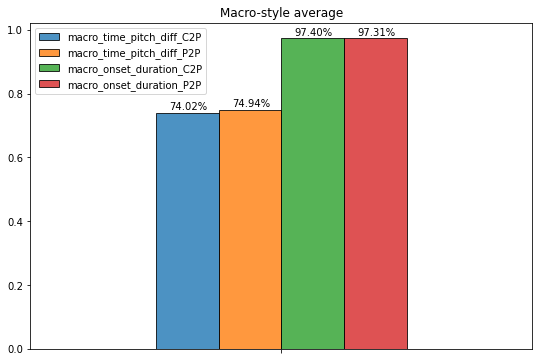

In [48]:
ax = style_macro.plot.bar(
    figsize=(9, 6), title="Macro-style average", ec="k", lw=1, alpha=0.8
)
autolabel(ax, orient="v", fmt="{:.2%}", xytext=(1, 1))
ax.set_xticklabels("")
plt.show()